# 1. B-Trees

### Definition

- A B-tree can be empty, if it is not none of its subtrees is.
- Each node of a B-tree contains a list of (increasingly) sorted keys. An **internal** node having $k$ keys has $(k+1)$ children we say it is a $(k+1)$-node.
- Key in position $i$ of a node has a left child and right one, respectively the $i$-th and $(i+1)$-st child. The keys of the left child are smaller than the $i$-th key and the ones of the right child bigger. In that sense a B-tree is a general search tree. 
- All leaves have the same depth.
- A B-tree has a degree $t > 1$ :
    - the root has at most $2t-1$ keys
    - any other node has at least $t-1$ keys and at most $2t-1$ ones.

In [1]:
from algopy import btree
from algopy.btree import BTree

In the previous implementation an empty B-tree is represented by the `None` object, a leaf by the fact its list of children is empty. The `degree` attribute is a class attribute, it enable to instantiate classes having a given degree. For example, for 2-4 trees we can define the class:

In [2]:
class B24(BTree):
    degree = 2

In [3]:
Dummy = B24([22], 
             [B24([15], 
                   [B24([8, 12]), B24([18, 19, 20])]), 
              B24([27, 41], 
                   [B24([24, 25]), B24([30, 35, 38]), B24([45, 48])])])

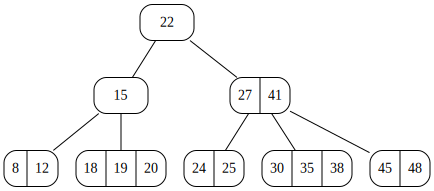

In [4]:
btree.display(Dummy)

## Exercice 1.3 : Linear Representation

### Serializing a B-Tree

In preordre treatment we print the list of keys of a node we close parenthesis in post-order. 

In [5]:
def __btreetolist(B):
    st = "(<"
    # Represent list of keys as strings
    for i in range(B.nbkeys -1):
        st += str(B.keys[i]) + ","
    st += str(B.keys[-1]) + ">"
    # Writing down recursive calls
    for child in B.children:
        st += __btreetolist(child)
    return st + ")"
    
def btreetolist(B):
    return __btreetolist(B) if B else ""

In [6]:
btreetolist(Dummy)

'(<22>(<15>(<8,12>)(<18,19,20>))(<27,41>(<24,25>)(<30,35,38>)(<45,48>)))'

In [7]:
btreetolist(None)

''

## Exercise 1.4 : B-Tree or not B-Tree

In [8]:
def dfs(B):
    if not B.children:
        for key in B.keys:
            print(key, end=" ")
    else:
        for i in range(B.nbkeys):
            dfs(B.children[i])
            print(B.keys[i], end=" ")
        dfs(B.children[B.nbkeys])

In [9]:
dfs(Dummy)

8 12 15 18 19 20 22 24 25 27 30 35 38 41 45 48 

In [10]:
def ordered(B):
    return _ordered(B, float("-inf"), float("inf"))

def _ordered(B, min_, max_):
    if B.children:
        #test range
        if B.keys[0] < min_ or B.keys[-1] > max_:
            return False
        for i in range(B.nbkeys):
            #recursive call
            if not _ordered(B.children[i], min_, B.keys[i]):
                return False
            min_ = B.keys[i]
        return _ordered(B.children[-1], B.keys[-1], max_)
    else:
        if B.keys[0] < min_ or B.keys[-1] > max_:
            return False
        for i in range(1, B.nbkeys):
            if B.keys[i - 1] > B.keys[i]:
                return False
        return True

In [11]:
ordered(Dummy)

True

# 2. Classics


## Exercice 2.1 : Minimum and maximum

### 1. Where do we find the minimal value of a B-tree, the maximal one?

The minimal one is found on the first leaf to the left ; it's its first key.


### 2. Write down the functions that enables us to get the minimal and maximal values of a B-tree.

In [12]:
def bmin(B):
    if B is None:
        raise Exception("B-Tree is empty.")
    while B.children:
        B = B.children[0]
    return B.keys[0]

In [13]:
bmin(Dummy)

8

Recurively

In [14]:
def _minbtree(B):
    if B.children:
        return _minbtree(B.children[0])
    return B.keys[0]
    
def minbtree(B):
    if B is None:
        raise Exception("B-Tree is empty.")
    return _minbtree(B)

In [15]:
minbtree(Dummy)

8

In [16]:
def bmax(B):
    if B is None:
        raise Exception("B-Tree is empty.")
    while B.children:
        B = B.children[-1]
    return B.keys[-1]

In [17]:
bmax(Dummy)

48

In [18]:
def _maxbtree(B):
    if B.children:
        return _maxbtree(B.children[-1])
    return B.keys[-1]
    
def maxbtree(B):
    if B is None:
        raise Exception("B-Tree is empty.")
    return _maxbtree(B)

In [19]:
maxbtree(Dummy)

48

## Exercice 2.2 : Search

A fonction searches for an element in a B-tree. It returns `(N, i)` if the element is key of node `N` at position `i` otherwise it returns `(N, i)` where `N` is the node element is supposed to be in at position `i`.

First the iterative version of binary search on a sorted list.

In [20]:
def ksearch(L, x):
    l, h = 0, len(L)
    while l < h:
        mid = (h + l) // 2
        # print("{} id in between [{}, {}]".format(mid, l, h))
        if L[mid] == x:
            return mid
        else:
            if L[mid] > x:
                h = mid
            else:
                l = mid + 1
    return l

In [21]:
L = [1, 2, 4, 5, 12, 23, 45, 90]
ksearch(L, 100)

8

In [22]:
L[8]

IndexError: list index out of range

In [23]:
def bsearch(B, x):
    i = ksearch(B.keys, x)
    if i < B.nbkeys and B.keys[i] == x:
        return B, i
    else:
        if not B.children:
            return None
        else:
            return bsearch(B.children[i], x)

In [24]:
bsearch(Dummy, 48)

(<__main__.B24 at 0x111fd9a20>, 1)

## Exercice 2.3 : Insert a New Element (Classical Approach)


### 1.a. Where can we insert an element in a B-tree while preserving its properties?

We insert at leaves.

### 1.b. What issues does it raise?

Can't insert if leaf is full.

### 1.c. What transformations can be done to solve theses issues? When are such transformations possible?

Splitting!

### 1.d. Write the insert function in case the parent is not filled and current node is not root.

In [25]:
def bsplit(A, i):
    """Split child i of node
    
    Splitting full child i of A assuming A has enough room 
    for median element
    
    """
    t = A.degree
    class BTree_t(BTree):
        degree = t 
    L, R = A.children[i], BTree_t()
    # Popping mid key in the list of keys of A
    A.keys.insert(i, L.keys.pop(t-1))
    # Updating list of children and keys of L and R
    L.keys, R.keys = L.keys[:t-1], L.keys[t-1:]
    L.children, R.children = L.children[:t], L.children[t:]
    # Linking R to the rest of the B-Tree
    A.children.insert(i+1, R)

In [26]:
subDummy = B24([15],[B24([8, 12]), B24([18, 19, 20])])

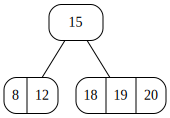

In [27]:
btree.display(subDummy)

In [28]:
bsplit(subDummy, 1)

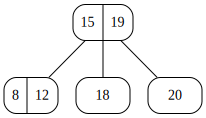

In [29]:
btree.display(subDummy)

### 2. Write insertion function in a B-tree while following precautionary principle.


In [30]:
def _binsert(A, x, t):
    i = ksearch(A.keys, x)
    if i == A.nbkeys or A.keys[i] != x:
        if not A.children:
            A.keys.insert(i, x)
        else:
            if A.children[i].nbkeys == 2*t - 1:
                bsplit(A, i)
                if A.keys[i] < x:
                    _binsert(A.children[i+1], x, t)
                elif A.keys[i] > x:
                    _binsert(A.children[i], x, t)
            else:
                _binsert(A.children[i], x, t)

def binsert(A, x, t): #Giving degree, needed when A is none.
    # Bad coding style
    class BTree_t(BTree):
        degree = t
    if not A:
        A = BTree_t([x])
    elif A.nbkeys == 2*t - 1:
        A = BTree_t([], [A])
        bsplit(A, 0)
        _binsert(A, x, t)
    else:
        _binsert(A, x, t)
    return A

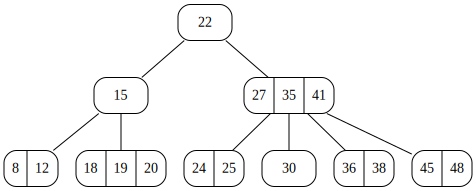

In [31]:
binsert(Dummy, 36, 2)
btree.display(Dummy)

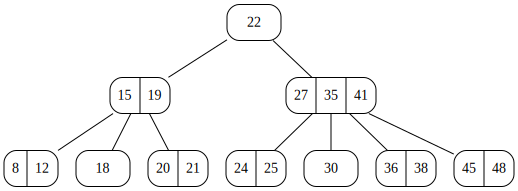

In [32]:
binsert(Dummy, 21, 2)
btree.display(Dummy)

# Exercice 2.4 : Deleting an element *down-way*

### 1. How to delete a key when it's not in a leaf.

You fetch either the biggest key of left child of current key or smallest one of right child ; overwrite the current key to delete with that one then call back to delete redundancy.

### 2. What approach adapted from AVLs can we put in place here?

Rotations!

### Left Rotation


In [33]:
def blr(A, i):
    """Rotation from child i+1 to child i.
    
    Conditions: 
    - the tree A exists, 
    - its child i exists and its root is not a 2t-node, 
    - its child i+1 exists and its root is not a t-node.
    
    """
    Cr = A.children[i+1]
    Cl = A.children[i]
    
    Cl.keys.append(A.keys[i])
    
    A.keys[i] = Cr.keys.pop(0)
    
    if Cr.children:
        Cl.children.append(Cr.children.pop(0))

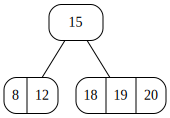

In [35]:
subDummy = B24([15],[B24([8, 12]), B24([18, 19, 20])])
btree.display(subDummy)

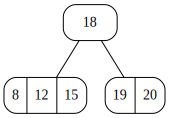

In [36]:
blr(subDummy, 0)
btree.display(subDummy)

### Right rotation

In [37]:
def brr(A, i):
    """Rotation from child i-1 to child i.
    
    Conditions: 
    - the tree A exists, 
    - its child i exists and its root is not a 2t-node, 
    - its child i-1 exists and its root is not a t-node.
    
    """
    Cr = A.children[i]
    Cl = A.children[i-1]
    
    Cr.keys.insert(0, A.keys[i-1])
    
    A.keys[i-1] = Cl.keys.pop()
    
    if Cl.children:
        Cr.children.insert(0, Cl.chidren.pop())

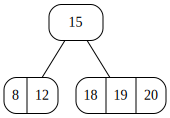

In [38]:
brr(subDummy, 1)
btree.display(subDummy)

### 3. What other problem can appear when deleting a key?

The fact there are not enough keys in neighbours of child we're following for search.

### Fusion

In [39]:
def fusion(A, i):
    """Merge A children i and i+1 into child i.
    
    Conditions: 
    - the tree A exists and its root is not a t-node,
    - children i and i+1 exist and their roots are t-nodes.
    
    """
    Cr = A.children[i+1]
    Cl = A.children[i]
    
    Cl.keys.append(A.keys.pop(i))
    
    Cl.keys += Cr.keys #creates a shallow copy
    Cl.children += Cr.children #creates a shallow copy 
    
    A.children.pop(i+1)

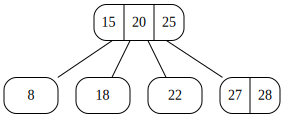

In [41]:
fusionDummy = B24([15,20,25],[B24([8]), B24([18]), B24([22]), B24([27, 28])])
btree.display(fusionDummy)

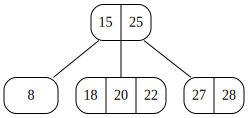

In [42]:
fusion(fusionDummy, 1)
btree.display(fusionDummy)

### 4. Following precautionary principle how can one proceed to delete keys in a B-tree?

Make sure there is always at least degree - 1 keys at any node we're following during search. This can be done by using rotations or fusion when no rotations are possible.

### Deletion in B-tree

In [47]:
def __delete(A, x):
    pos = ksearch(A.keys, x)
    if A.children:
        if pos < A.nbkeys and A.keys[pos] == x:
            if A.children[pos].nbkeys > A.children[pos + 1].nbkeys:
                A.keys[pos] = maxbtree(A.children[pos])
                __delete(A.children[pos], A.keys[pos])
            elif A.children[pos+1].nbkeys > A.degree - 1:
                A.keys[pos] = minbtree(A.children[pos+1])
                __delete(A.children[pos+1], A.keys[pos])
            else:
                fusion(A, pos) # notice that you always have a right child in this case
                __delete(A.children[pos], x)
        else:        
            if A.children[pos].nbkeys == A.degree - 1:
                if pos > 0 and A.children[pos - 1].nbkeys > A.degree - 1:
                    brr(A, pos)
                elif pos < A.nbkeys and A.children[pos + 1].nbkeys > A.degree - 1:
                    blr(A, pos)
                else:
                    if pos == A.nbkeys:
                        fusion(A, pos-1)
                    else:
                        fusion(A, pos)
            __delete(A.children[pos], x)
    else:
        if pos < A.nbkeys and A.keys[pos] == x:
            A.keys.pop(pos)

def delete(A, x):
    if A:
        __delete(A, x) 
        if A.nbkeys > 0:
            return A
        elif A.children:
            return A.children[0]
    else:
        raise Exception("You're trying to delete from an empty tree")

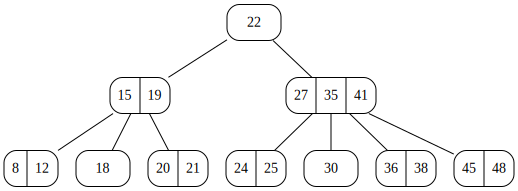

In [48]:
btree.display(Dummy)

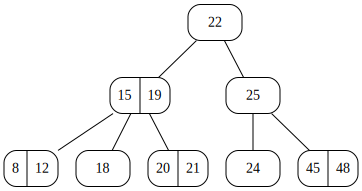

In [55]:
Dummy = delete(Dummy, 41)
btree.display(Dummy)